In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.feature_selection import VarianceThreshold, f_regression, SelectKBest, RFE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['price'] = boston.target
df.head()

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Variance Threshold
$$Var(X) = E[(X - \mu)^2]$$

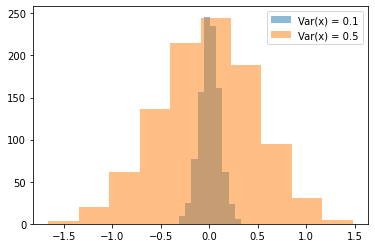

In [3]:
x1 = np.random.normal(0, 0.1, 1000)
x2 = np.random.normal(0, 0.5, 1000)
plt.hist(x1, alpha=0.5, label='Var(x) = 0.1')
_ = plt.hist(x2, alpha=0.5, label='Var(x) = 0.5')
plt.legend()

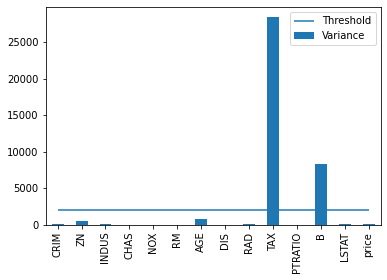

In [4]:
ax = df.var(0).plot(kind='bar', label='Variance')
ax.hlines(2000, 0, 13, label='Threshold')
plt.legend()

In [5]:
vt = VarianceThreshold(threshold=2000)
x_reduced = vt.fit_transform(df)
df.columns[vt.get_support()]

Index(['TAX', 'B'], dtype='object')

In [6]:
x_reduced

array([[296.  , 396.9 ],
       [242.  , 396.9 ],
       [242.  , 392.83],
       ...,
       [273.  , 396.9 ],
       [273.  , 393.45],
       [273.  , 396.9 ]])

In [7]:
df.var(0)

CRIM          73.986578
ZN           543.936814
INDUS         47.064442
CHAS           0.064513
NOX            0.013428
RM             0.493671
AGE          792.358399
DIS            4.434015
RAD           75.816366
TAX        28404.759488
PTRATIO        4.686989
B           8334.752263
LSTAT         50.994760
price         84.586724
dtype: float64

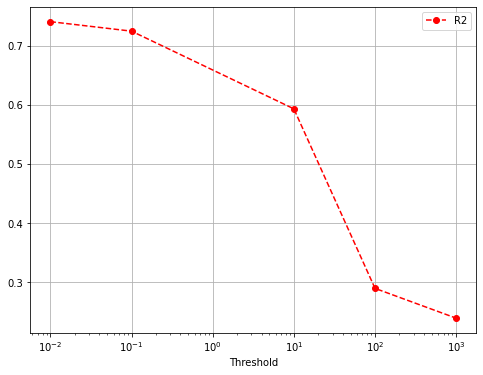

In [8]:
X = boston.data
y = boston.target

thresholds = [0.01, 0.1, 10, 100, 1000]
r2 = []
n_cols = []

for t in thresholds:
    vt = VarianceThreshold(threshold=t)
    x_red = vt.fit_transform(X)
    n_cols.append(x_red.shape[1])
    lr = LinearRegression().fit(x_red, y)
    p = lr.predict(x_red)
    r2.append(r2_score(y, p))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, r2, 'ro--', label='R2')
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('Threshold')
_ = ax.legend()

### Exercise: Perform variance thresholding on the Diabetes dataset
### *Hint*: Look at the variances beforehand and decide the set of thresholds

In [9]:
diabetes = datasets.load_diabetes()

In [10]:
# enter code here
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['price'] = diabetes.target
X = diabetes.data
y = diabetes.target

## Selecting the $k$ best features

In [11]:
k = 3
selector = SelectKBest(f_regression, k=k)
x_red = selector.fit_transform(X, y)
x_red.shape

(442, 3)

In [12]:
lr.fit(x_red, y)
lr.score(x_red, y)

0.48008281990946056

In [13]:
K = list(range(1, X.shape[1] + 1))
K

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

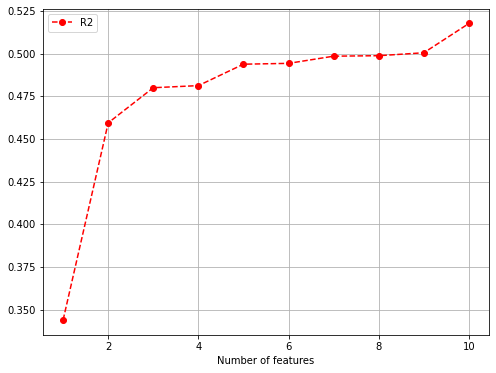

In [14]:
r2 = []

for k in K:
    selector = SelectKBest(f_regression, k=k)
    x_red = selector.fit_transform(X, y)
    lr = LinearRegression().fit(x_red, y)
    r2.append(lr.score(x_red, y))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(K, r2, 'ro--', label='R2')
ax.grid()
ax.set_xlabel('Number of features')
_ = ax.legend()

### Exercise: Find how many "best" features are optimal for the Diabetes dataset

In [15]:
# enter code here
thresh_r2 = 0.475
features_above_thresh_R2 = [(k, r) for k, r in zip(K, r2) if r > thresh_r2]
min_num_features = features_above_thresh_R2[0][0]
print(min_num_features)

3


## Recursive Feature Elimination

In [16]:
columns = df.drop(['price'], axis=1).columns

lr = LinearRegression()
rfe = RFE(lr, step=1, verbose=1)
x_red = rfe.fit_transform(X, y)

lr.fit(x_red, y)
print(lr.score(x_red, y))

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
0.49891471641850904


In [17]:
# Which columns are kept?
columns[rfe.get_support()]

Index(['bmi', 'bp', 's1', 's2', 's5'], dtype='object')

In [18]:
rfe = RFE(lr, n_features_to_select=3, step=1, verbose=1)
x_red = rfe.fit_transform(X, y)

lr.fit(x_red, y)
print(lr.score(x_red, y))

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
0.47002448720669265


## Exercise: Find the R2 score with the 3 best columns in the diabetes dataset.
### Which are these three columns?

In [19]:
# enter code here
columns[rfe.get_support()]

Index(['bmi', 's1', 's5'], dtype='object')